In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict

np.random.seed(8)

In [2]:
def point_inside_circle(node1, obstacle) -> bool:
    """Calculates if a points falls inside an obstacle

    Args:
        node1 (Tuple[float, float]): Sampled node
        obstacle (Tuple[float, float, float]): Obstacle to be checked

    Returns:
        bool: True if node falls inside obstacle, else False
    """
    cx, cy, r = obstacle
    x1, y1 = node1
    # Check if point is inside the circle
    return False if math.sqrt((x1 - cx) ** 2 + (y1 - cy) ** 2) > r else True


def circle_line_intersection(node1, node2, obstacle) -> bool:
    """Check if line intersects with circle

    Args:
        node1 (_type_): The (x, y) location of the first node
        node2 (_type_): The (x, y) location of the second node
        obstacle (_type_): The (x, y, r) location and radius of the obstacle

    Returns:
        bool: True if line intersectecs with circle, else False
    """

    from shapely.geometry import LineString, Point

    x1, y1 = node1
    x2, y2 = node2
    cx, cy, r = obstacle

    p_o = Point((cx, cy))
    c = p_o.buffer(r).boundary
    l = LineString([(x1, y1), (x2, y2)])
    i = c.intersection(l)

    return False if i.is_empty else True


In [3]:
def find_k_nearest_neighbors(nodes, k):
    """Findes the indicies of the K nearest neighbors of to any give node

    Args:
        nodes (List[Tuple[float, float]]): List of the nodes positions
        k (int): Number of nearest nodes to connect to

    Returns:
        dict: dictionary where the key-value pairs are:  node_idx: [neighbor_1_idx, neighbor_2_idx, ..., neighbor_k_idx]
    """
    node_neighbors = defaultdict(list)

    for i, node1 in enumerate(nodes):
        distances = []
        for j, node2 in enumerate(nodes):
            if i != j:
                (x1, y1), (x2, y2) = node1, node2
                dist = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
                distances.append((dist, j))
        k_nearest = sorted(distances)[:k]
        for _, neighbor_idx in k_nearest:
            node_neighbors[i].append(neighbor_idx)

    return node_neighbors


In [4]:
class PRM:
    def __init__(self, num_nodes, map_size, num_neighbors):
        self.num_nodes = num_nodes
        self.map_size = map_size
        self.num_neighbors = num_neighbors
        self.obstacles = []
        self.nodes = []     # list of (x,y) tuples
        self.node_neighbors = None
        self.edges = defaultdict(list)  # dict of node_idx: [(neighbor_idx, distance), ...]

        self.start = None
        self.start_idx = None

        self.goal = None
        self.goal_idx = None

    def generate_random_nodes(self):
        for _ in range(self.num_nodes):
            collides = True
            while collides:
              x = np.random.uniform(0, self.map_size)
              y = np.random.uniform(0, self.map_size)
              # Check if nodes collides with obstacles
              node = (x, y)
              if not self.collides_with_obstacle(node):
                collides = False
            self.nodes.append(node)

    def compute_edges(self):
        # Calculate the k-nearest neighbors, and store them for future use.
        self.node_neighbors = find_k_nearest_neighbors(self.nodes, self.num_neighbors)

        # For each neighbor, check if the direct path is obstacle free.
        for i, node in enumerate(self.nodes):
            # print(f"Node {i} has {len(self.node_neighbors[i])} neighbors")
            for neighbor_idx in self.node_neighbors[i]:
                neighbor = self.nodes[neighbor_idx]
                # If path is free, calculate distance and create the edge
                if not self.path_collides_obstacle(node, neighbor):
                    dist = math.sqrt((node[0] - neighbor[0]) ** 2 + (node[1] - neighbor[1]) ** 2)
                    if (neighbor_idx, dist) not in self.edges[i]:
                        self.edges[i].append((neighbor_idx, dist))
                    if (i, dist) not in self.edges[neighbor_idx]:
                        self.edges[neighbor_idx].append((i, dist))
                    

    def collides_with_obstacle(self, node1):
        for obstacle in self.obstacles:
            if point_inside_circle(node1, obstacle):
                return True
        return False

    def path_collides_obstacle(self, node1, node2):
        for obstacle in self.obstacles:
            if circle_line_intersection(node1, node2, obstacle):
                return True
        return False

    def add_start_and_goal(self, start, goal):
        """
        Add start and goal points to the roadmap.

        Args:
            start (Tuple[float, float]): Start position
            goal (Tuple[float, float]): Goal position
        """
        if self.collides_with_obstacle(start):
            print("Error: Starting point is not valid")
            exit(-1)

        if self.collides_with_obstacle(goal):
            print("Error: Goal point is not valid")
            exit(-1)

        # Set start and goal positions, and add them to the nodes
        self.start, self.goal = start, goal

        self.start_idx = len(self.nodes)
        self.nodes.append(start)

        self.goal_idx = len(self.nodes)
        self.nodes.append(goal)

        # Find nearest node
        neighbours = find_k_nearest_neighbors(self.nodes, k=1)
        # Get the closest (first) neighbour to the star and goal positions
        goal_neighbour_idx = neighbours[self.goal_idx][0]
        start_neighbour_idx = neighbours[self.start_idx][0]

        goal_neighbour = self.nodes[goal_neighbour_idx]
        start_neighbour = self.nodes[start_neighbour_idx]

        # computed distances
        d_goal = math.sqrt((goal[0] - goal_neighbour[0]) ** 2 + (goal[1] - goal_neighbour[1]) ** 2)
        d_start = math.sqrt((start[0] - start_neighbour[0]) ** 2 + (start[1] - start_neighbour[1]) ** 2)

        self.edges[goal_neighbour_idx].append((self.goal_idx, d_goal))
        self.edges[start_neighbour_idx].append((self.start_idx, d_start))
        self.edges[self.goal_idx].append((goal_neighbour_idx, d_goal))
        self.edges[self.start_idx].append((start_neighbour_idx, d_start))

    def add_obstacle(self, x, y, radius):
        self.obstacles.append((x, y, radius))

    def plot(self):
        plt.figure(dpi=150)
        for node_idx, edges in self.edges.items():
            for edge in edges:
                node1 = self.nodes[node_idx]
                node2 = self.nodes[edge[0]]
                plt.plot([node1[0], node2[0]], [node1[1], node2[1]], "b-")
        for i, node in enumerate(self.nodes):
            plt.plot(node[0], node[1], "ro")
            plt.text(node[0], node[1], str(i), ha='center', va='center')
        for obstacle in self.obstacles:
            circle = plt.Circle(
                (obstacle[0], obstacle[1]), obstacle[2], color="gray", alpha=0.5
            )
            plt.gca().add_patch(circle)

        if self.goal:
            plt.plot(self.goal[0], self.goal[1], "yo")
        if self.start:
            plt.plot(self.start[0], self.start[1], "go")

        plt.title("Probabilistic Roadmap with Obstacles")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.grid(True)
        plt.show()

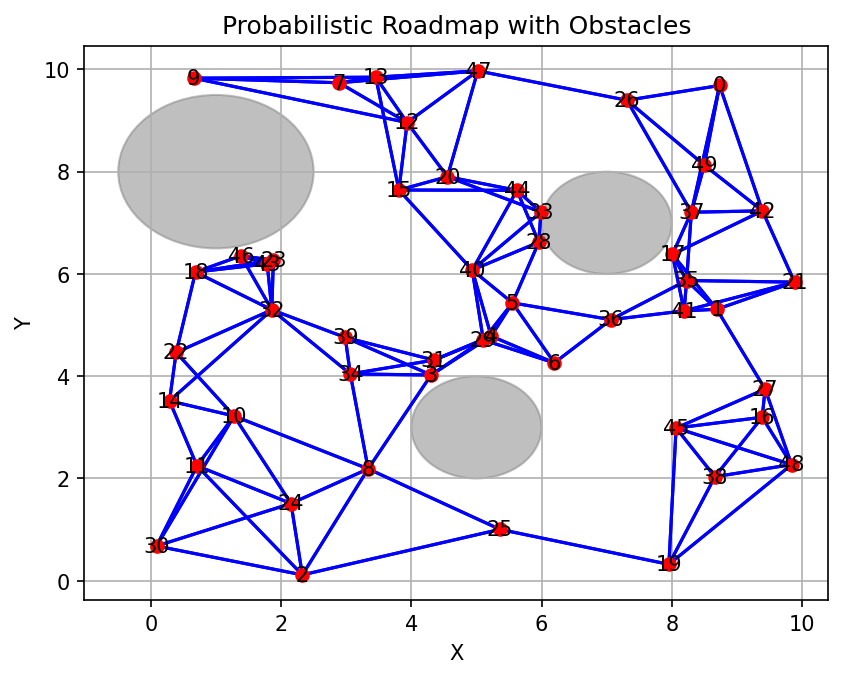

In [5]:
map_size = 10  # Map size in both x, and y dimensions
num_nodes = 50  # Number of nodes to sampled
num_neighbors = 4  # Number of connected neighbors to each node

# Create the Probabilistic Roadmap
prm = PRM(num_nodes, map_size, num_neighbors)

# Add obstacles
prm.add_obstacle(5, 3, 1)
prm.add_obstacle(7, 7, 1)
prm.add_obstacle(1, 8, 1.5)

# Sample the state space and connect the nodes
prm.generate_random_nodes()
prm.compute_edges()

# Plot the final road Map
prm.plot()

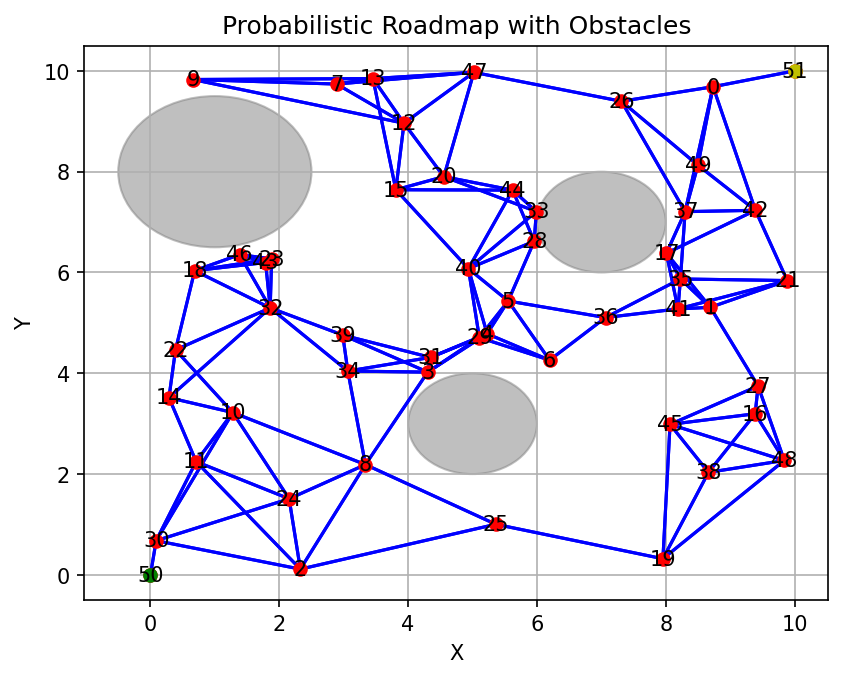

In [6]:
# Add starting and ending positions
prm.add_start_and_goal(start=[0, 0], goal=[10, 10])
prm.plot()

In [7]:
prm.nodes

[(8.734294027918162, 9.68540662820932),
 (8.691945402139199, 5.3085569155559895),
 (2.327283279772907, 0.11398804277429897),
 (4.304688182924905, 4.023513600373648),
 (5.226746713525696, 4.783917958024024),
 (5.553564738223304, 5.433860175425403),
 (6.196820961034396, 4.260917704761922),
 (2.8907502801808773, 9.738552412004463),
 (3.3377404551067036, 2.1880106081982795),
 (0.6580838778721143, 9.828705465534338),
 (1.2785571292503184, 3.2213079320417934),
 (0.7094284475019874, 2.247699389680454),
 (3.936349149436049, 8.961450048806352),
 (3.4546161199786707, 9.847494372852713),
 (0.287320489632954, 3.516847362701201),
 (3.80958889203853, 7.641601313659601),
 (9.388039133107718, 3.196897964670277),
 (8.010558863263945, 6.382388061231214),
 (0.6869013345815722, 6.0364447636911125),
 (7.955745584289766, 0.32008156425796797),
 (4.55447822105933, 7.901725413382856),
 (9.885965181137292, 5.839645435009667),
 (0.38912297642321847, 4.464229075179026),
 (1.8817251529331425, 6.270556468552484),
 

In [8]:
prm.edges

defaultdict(list,
            {0: [(26, 1.4517451386029263),
              (49, 1.5748216536987167),
              (37, 2.5162800908993272),
              (42, 2.538274841247924),
              (51, 1.304216468742156)],
             26: [(0, 1.4517451386029263),
              (49, 1.7378120266220491),
              (47, 2.361792755022314),
              (37, 2.402728359254403)],
             49: [(0, 1.5748216536987167),
              (26, 1.7378120266220491),
              (37, 0.9426307852630231),
              (42, 1.2634659246669069)],
             37: [(0, 2.5162800908993272),
              (17, 0.8739312068956546),
              (26, 2.402728359254403),
              (35, 1.3374589675567496),
              (49, 0.9426307852630231),
              (42, 1.091760004029132)],
             42: [(0, 2.538274841247924),
              (21, 1.4790953023732412),
              (37, 1.091760004029132),
              (49, 1.2634659246669069),
              (17, 1.6227921405129488)],
          

In [9]:
def dijkstra(edges, start_idx, goal_idx):
    '''
    Use dijkstra algorithm to find the shortest path from start to goal.

    Args:
        edges (dict): dictionary where the key-value pairs are:  node_idx: [(neighbor_idx, distance), ...]
        start_idx (int): index of the start node
        goal_idx (int): index of the goal node

    Returns:
        dict: dictionary where the key-value pairs are:  node_idx: distance
        path: list of the node indexes in the shortest path
    '''
    print(f"Finding path from {start_idx} to {goal_idx} using Dijkstra algorithm.")

    class Node:
        def __init__(self, idx):
            self.idx = idx
            self.parent = None

    # Initialize the distance to all nodes to be infinity
    distances = {}
    nodes = {}
    for node in edges:
        distances[node] = float("inf")
        nodes[node] = Node(node)

    # Initialize start node
    distances[start_idx] = 0
    nodes[start_idx].parent = start_idx

    queue = [(start_idx, 0)]  # priority queue: store nodes and their distances
    visited = set()           # store visited nodes

    # Iterate through the queue
    while queue:
        current_node, current_distance = queue.pop(0)

        if current_node in visited:
            continue

        # Check if the current node is the goal node
        if current_node == goal_idx:
            print(f"Visited {len(visited)} nodes")
            print(f"Goal node {goal_idx} found with distance {current_distance}")

            # Reconstruct the path
            path = []
            while current_node != start_idx:
                path.append(current_node)
                current_node = nodes[current_node].parent
            path.append(start_idx)
            path.reverse()
            print(f"Path: {path}")
            break

        # Explore the neighbors of the current node
        for neighbor, distance in edges[current_node]:
            # Relax the current node if a lower distance estimate is found
            new_estimate = current_distance + distance
            if new_estimate < distances[neighbor]:
                distances[neighbor] = new_estimate
                nodes[neighbor].parent = current_node
            queue.append((neighbor, distances[neighbor]))

        visited.add(current_node)

        # Sort the queue based on the distances
        queue.sort(key=lambda x: x[1])
    
    return distances, path

In [10]:
distances, path = dijkstra(prm.edges, prm.start_idx, prm.goal_idx)

Finding path from 50 to 51 using Dijkstra algorithm.
Visited 51 nodes
Goal node 51 found with distance 16.344993358335646
Path: [50, 30, 24, 8, 3, 29, 6, 36, 35, 37, 0, 51]


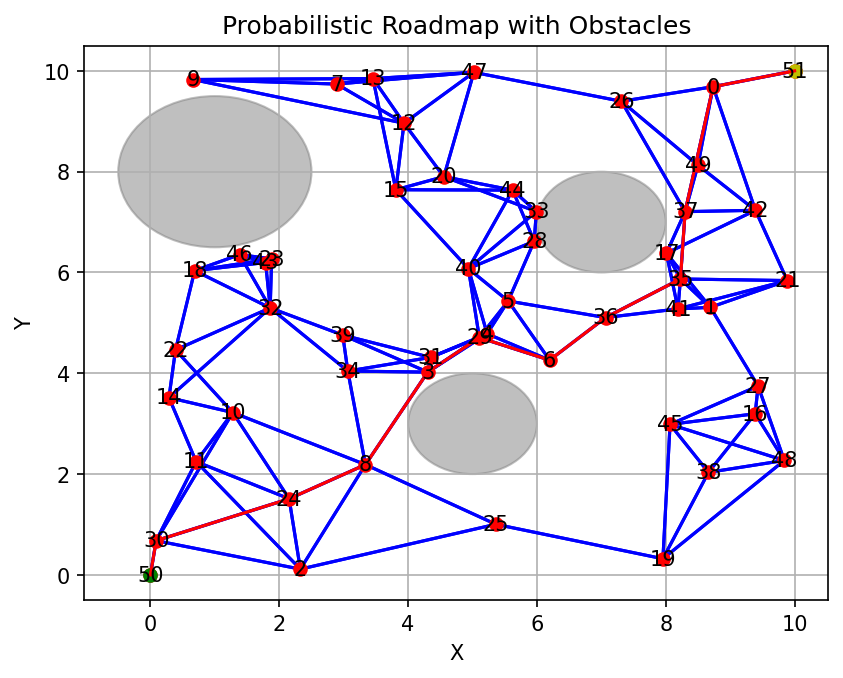

In [11]:
def plot_path(nodes, edges, obstacles, goal, start, path) -> None:
    '''
    Plot the path as red edges on the map.

    Args:
        nodes (List[Tuple[float, float]]): list of the nodes x-y positions
        edges (dict): key-value pairs are {node_idx: [(neighbor_idx, distance), ...]}
        obstacles (List[Tuple[float, float, float]]): list of the circle obstacles as (x, y, r)
        goal (Tuple[float, float]): goal x-y position
        start (Tuple[float, float]): start x-y position
        path (List[int]): list of the node indexes in the shortest path
    '''
    # Plot map
    plt.figure(dpi=150)
    for node_idx, edges in edges.items():
        for edge in edges:
            node1 = nodes[node_idx]
            node2 = nodes[edge[0]]
            plt.plot([node1[0], node2[0]], [node1[1], node2[1]], "b-")
    for i, node in enumerate(nodes):
        plt.plot(node[0], node[1], "ro")
        plt.text(node[0], node[1], str(i), ha='center', va='center')
    for obstacle in obstacles:
        circle = plt.Circle(
            (obstacle[0], obstacle[1]), obstacle[2], color="gray", alpha=0.5
        )
        plt.gca().add_patch(circle)

    if goal:
        plt.plot(goal[0], goal[1], "yo")
    if start:
        plt.plot(start[0], start[1], "go")

    # Plot the path
    for i in range(len(path) - 1):
        node1 = nodes[path[i]]
        node2 = nodes[path[i + 1]]
        plt.plot([node1[0], node2[0]], [node1[1], node2[1]], "r-")

    plt.title("Probabilistic Roadmap with Obstacles")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()


plot_path(prm.nodes, prm.edges, prm.obstacles, prm.goal, prm.start, path)